In [1]:
import os 
os.environ['http_proxy'] = 'http://proxy:80'
os.environ['https_proxy'] = 'http://proxy:80'

# Masked Autoencoder

Implementation of [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/pdf/2111.06377.pdf) paper on CIFAR datasets.
A small ViT(introduced in [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)) is trained on CIFAR 100 dataset and then evaluated on CIFAR 10 dataset on a downstream classification task.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

import numpy as np
import matplotlib.pyplot as plt
import random

2024-08-23 13:09:08.218944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 13:09:08.246071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 13:09:08.254440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 13:09:08.276555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 13:09:11.236906: W tensorflow/compiler/tf2

In [3]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
AUTO = tf.data.AUTOTUNE

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_valid)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 50000
Testing samples: 10000


2024-08-23 13:09:17.260674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-08-23 13:09:17.261422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10525 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-08-23 13:09:17.262064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10525 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1
2024-08-23 13:09:17.262696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10525 MB memory:  -> device: 3, name: NVIDIA GeForce

# Augmentation

The authors of this paper point out that Masked Autoencoders do not rely on augmentations hence propose a simple augmentation pipeline of:
* Resizing
* Random cropping
* Random horizontal flipping

In [4]:
IMAGE_SIZE = 72  
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

**A layer for extracting patches from images**

This layer takes images as input and divides them into patches. 

In [6]:
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 50.


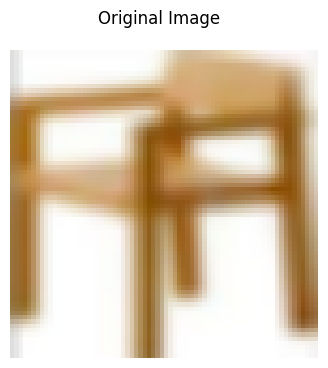

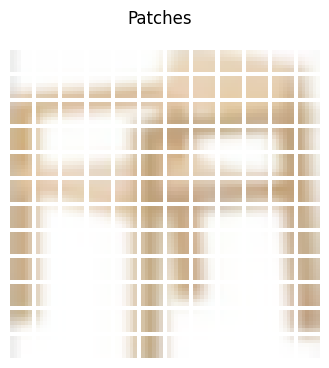

In [7]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Model

In [8]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 64
DEC_PROJECTION_DIM = 48
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    4
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
] 
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [9]:
EPOCHS = 75
DOWNSTREAM_EPOCHS = 50

**Encoder and Patch Masking**

This layer includes masking and encoding the patches.

In [10]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        ) 
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            ) 
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

**Dense Projection**

In [11]:
def dense_projection(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

**MAE Encoder**

In [12]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

**MAE Decoder**

In [13]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = L.Flatten()(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

**MAE Trainer**

In [14]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


**Monitoring Callback**

In [15]:
test_images = next(iter(valid_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [16]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

opt = keras.optimizers.Adam(amsgrad=True)
mae_model.compile(
    optimizer=opt, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

In [17]:
encoder.summary()

Model: "mae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 64)  │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 64)  │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 64)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 499,328 (1.90 MB)

 Trainable params: 499,328 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
decoder.summary()

Model: "mae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 144, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 144, 48)   │      3,120 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 48)   │         96 │ dense_12[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 48)   │     37,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 144, 48)   │          0 │ multi_head_atten… │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 48)   │         96 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 144, 96)   │      4,704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 144, 96)   │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 144, 48)   │      4,656 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 144, 48)   │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 144, 48)   │          0 │ dropout_20[0][0], │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 48)   │         96 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 48)   │     37,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 144, 48)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 48)   │         96 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 144, 96)   │      4,704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 144, 96)   │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 144, 48)   │      4,656 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 107,702,352 (410.85 MB)

 Trainable params: 107,702,352 (410.85 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [20]:
keras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")
keras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 60))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=12)
ax[0].axis("off")
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=12)
ax[1].axis("off");

AttributeError: module 'pydot' has no attribute 'InvocationException'

Epoch 1/75


/home/hpc/rlvl/rlvl115h/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:617: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/hpc/rlvl/rlvl115h/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - mae: 0.1913 - loss: 0.4762
Idx chosen: 23


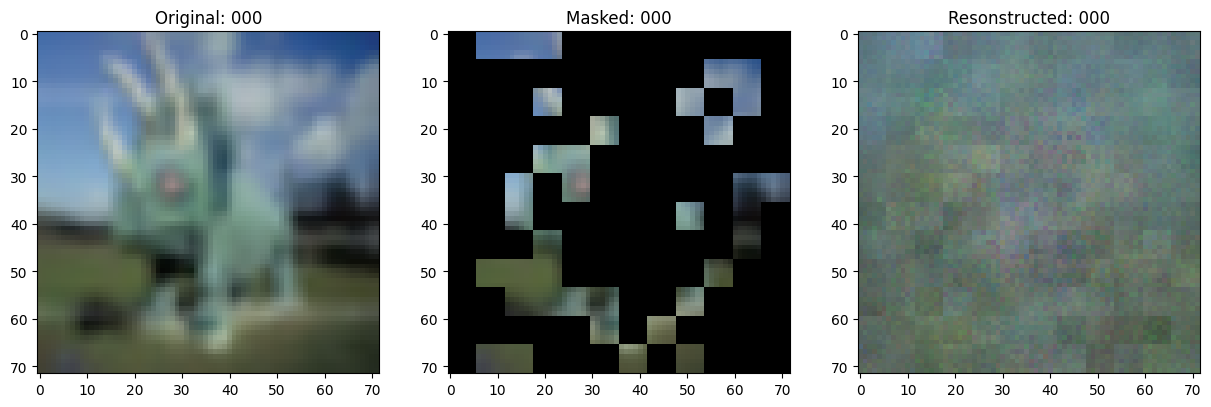

196/196 ━━━━━━━━━━━━━━━━━━━━ 81s 238ms/step - mae: 0.1912 - loss: 0.4762 - val_loss: 0.5023 - val_mae: 0.1613 - learning_rate: 0.0010
Epoch 2/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - mae: 0.1521 - loss: 0.4788 - val_loss: 0.4925 - val_mae: 0.1377 - learning_rate: 0.0010
Epoch 3/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 224ms/step - mae: 0.1328 - loss: 0.4784 - val_loss: 0.4697 - val_mae: 0.1288 - learning_rate: 0.0010
Epoch 4/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 227ms/step - mae: 0.1231 - loss: 0.4781 - val_loss: 0.4855 - val_mae: 0.1196 - learning_rate: 0.0010
Epoch 5/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - mae: 0.1153 - loss: 0.4781 - val_loss: 0.4862 - val_mae: 0.1158 - learning_rate: 0.0010
Epoch 6/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.1093 - loss: 0.4783
Idx chosen: 244


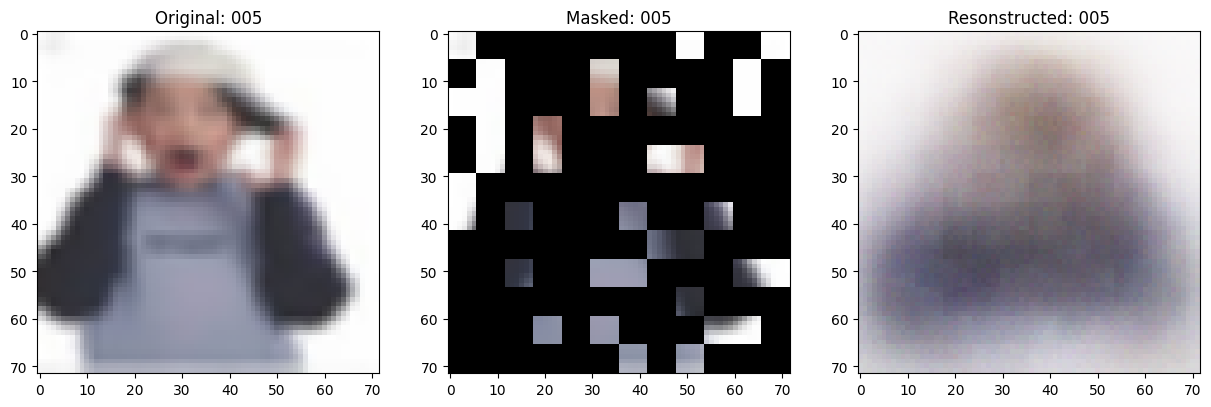

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 234ms/step - mae: 0.1093 - loss: 0.4783 - val_loss: 0.4780 - val_mae: 0.1082 - learning_rate: 0.0010
Epoch 7/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.1038 - loss: 0.4778 - val_loss: 0.4723 - val_mae: 0.1050 - learning_rate: 0.0010
Epoch 8/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.1005 - loss: 0.4778
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.1005 - loss: 0.4778 - val_loss: 0.4784 - val_mae: 0.1021 - learning_rate: 0.0010
Epoch 9/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0964 - loss: 0.4780 - val_loss: 0.4791 - val_mae: 0.0992 - learning_rate: 1.0000e-04
Epoch 10/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0955 - loss: 0.4777 - val_loss: 0.4813 - val_mae: 0.0987 - learning_rate: 1.0000e-04
Epoch 11/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0952 - loss: 0.4778
Idx chosen: 129


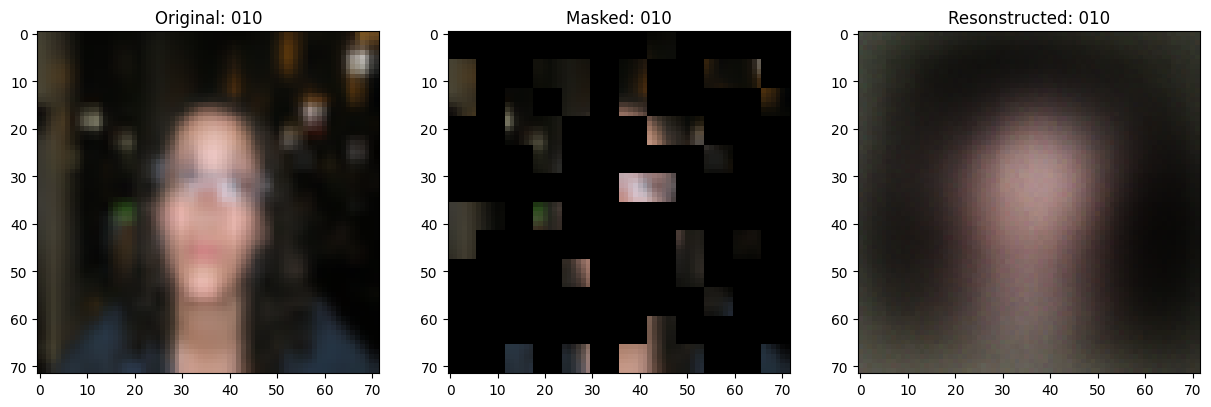

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0952 - loss: 0.4778 - val_loss: 0.4808 - val_mae: 0.0984 - learning_rate: 1.0000e-04
Epoch 12/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0948 - loss: 0.4781 - val_loss: 0.4821 - val_mae: 0.0979 - learning_rate: 1.0000e-04
Epoch 13/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0945 - loss: 0.4778
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0945 - loss: 0.4778 - val_loss: 0.4780 - val_mae: 0.0974 - learning_rate: 1.0000e-04
Epoch 14/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0939 - loss: 0.4778 - val_loss: 0.4789 - val_mae: 0.0973 - learning_rate: 1.0000e-05
Epoch 15/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 233ms/step - mae: 0.0939 - loss: 0.4777 - val_loss: 0.4779 - val_mae: 0.0973 - learning_rate: 1.0000e-05
Epoch 16/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0939 - loss: 0.4779
Idx chosen: 48


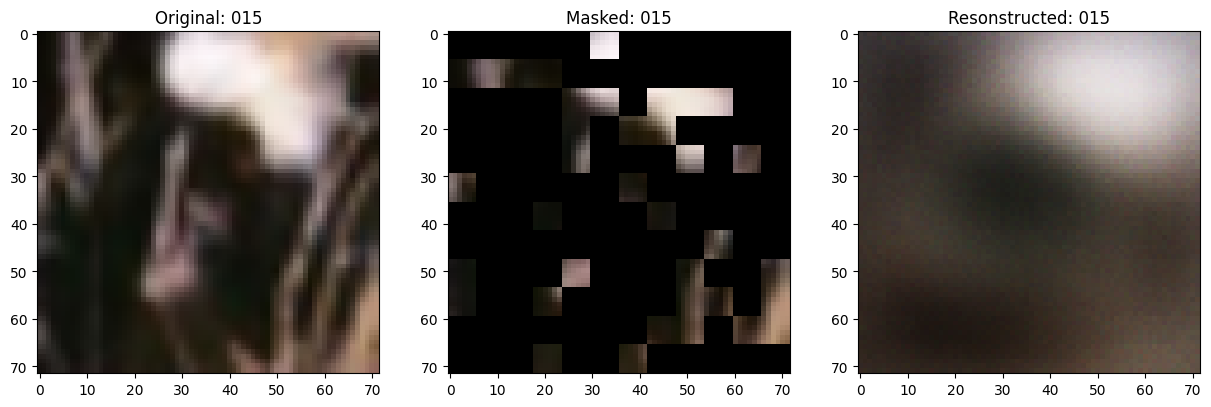

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0939 - loss: 0.4779 - val_loss: 0.4784 - val_mae: 0.0972 - learning_rate: 1.0000e-05
Epoch 17/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4779 - val_loss: 0.4782 - val_mae: 0.0972 - learning_rate: 1.0000e-05
Epoch 18/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4777
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4777 - val_loss: 0.4780 - val_mae: 0.0971 - learning_rate: 1.0000e-05
Epoch 19/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - mae: 0.0936 - loss: 0.4775 - val_loss: 0.4784 - val_mae: 0.0971 - learning_rate: 1.0000e-06
Epoch 20/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0938 - loss: 0.4778 - val_loss: 0.4790 - val_mae: 0.0972 - learning_rate: 1.0000e-06
Epoch 21/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4781
Idx chosen: 245


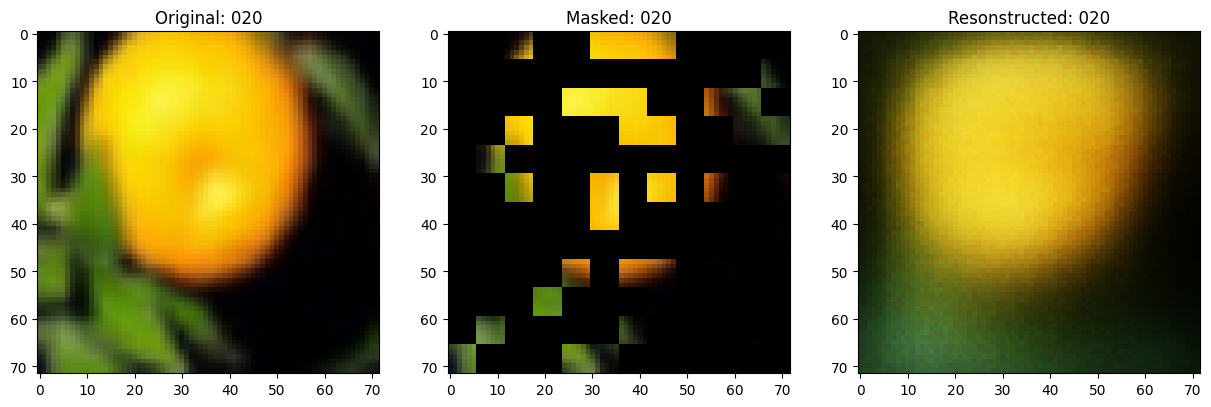

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0936 - loss: 0.4781 - val_loss: 0.4788 - val_mae: 0.0972 - learning_rate: 1.0000e-06
Epoch 22/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4781 - val_loss: 0.4788 - val_mae: 0.0971 - learning_rate: 1.0000e-06
Epoch 23/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4779
Epoch 23: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4787 - val_mae: 0.0970 - learning_rate: 1.0000e-06
Epoch 24/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - mae: 0.0936 - loss: 0.4781 - val_loss: 0.4788 - val_mae: 0.0970 - learning_rate: 1.0000e-07
Epoch 25/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4788 - val_mae: 0.0970 - learning_rate: 1.0000e-07
Epoch 26/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4776
Idx chosen: 198


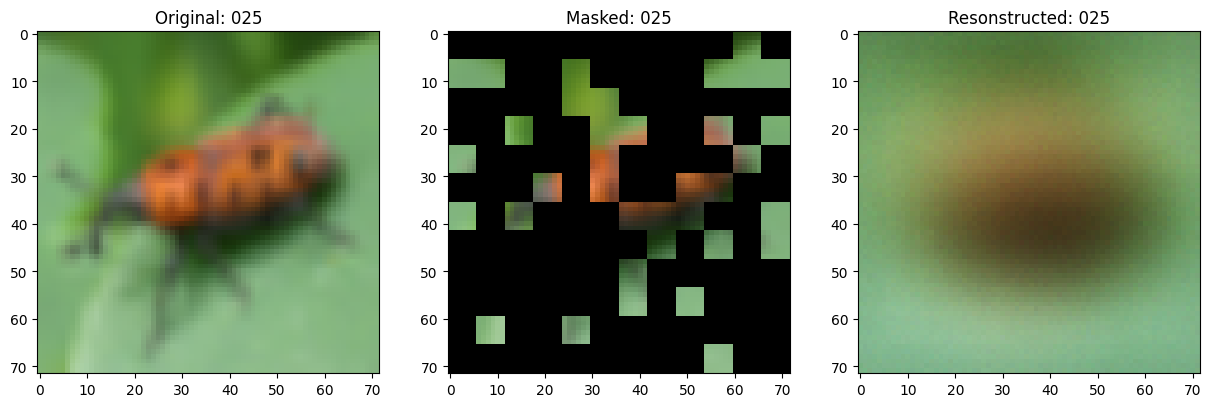

196/196 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4787 - val_mae: 0.0972 - learning_rate: 1.0000e-07
Epoch 27/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - mae: 0.0935 - loss: 0.4779 - val_loss: 0.4784 - val_mae: 0.0970 - learning_rate: 1.0000e-07
Epoch 28/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4778
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4783 - val_mae: 0.0970 - learning_rate: 1.0000e-07
Epoch 29/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4787 - val_mae: 0.0969 - learning_rate: 1.0000e-08
Epoch 30/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0937 - loss: 0.4780 - val_loss: 0.4787 - val_mae: 0.0972 - learning_rate: 1.0000e-08
Epoch 31/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4778
Idx chosen: 96


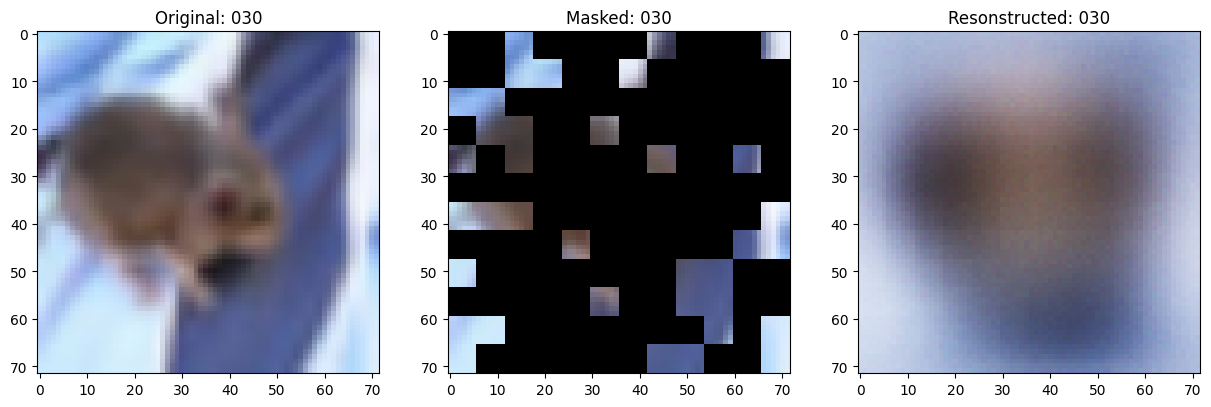

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-08
Epoch 32/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4785 - val_mae: 0.0971 - learning_rate: 1.0000e-08
Epoch 33/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4780
Epoch 33: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4785 - val_mae: 0.0972 - learning_rate: 1.0000e-08
Epoch 34/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4777 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-09
Epoch 35/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0970 - learning_rate: 1.0000e-09
Epoch 36/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0937 - loss: 0.4778
Idx chosen: 46


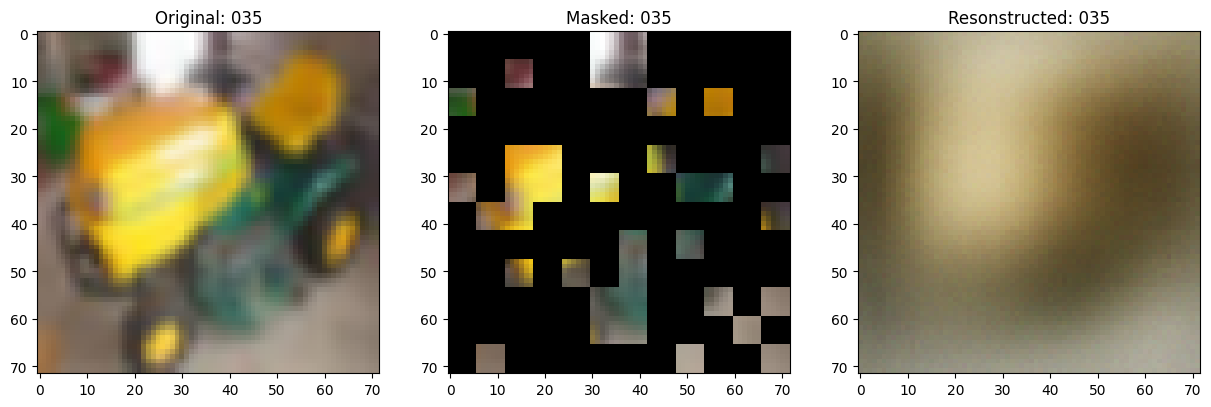

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0937 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-09
Epoch 37/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0970 - learning_rate: 1.0000e-09
Epoch 38/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4778
Epoch 38: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 233ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4784 - val_mae: 0.0972 - learning_rate: 1.0000e-09
Epoch 39/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4788 - val_mae: 0.0971 - learning_rate: 1.0000e-10
Epoch 40/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0937 - loss: 0.4779 - val_loss: 0.4783 - val_mae: 0.0971 - learning_rate: 1.0000e-10
Epoch 41/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4777
Idx chosen: 15


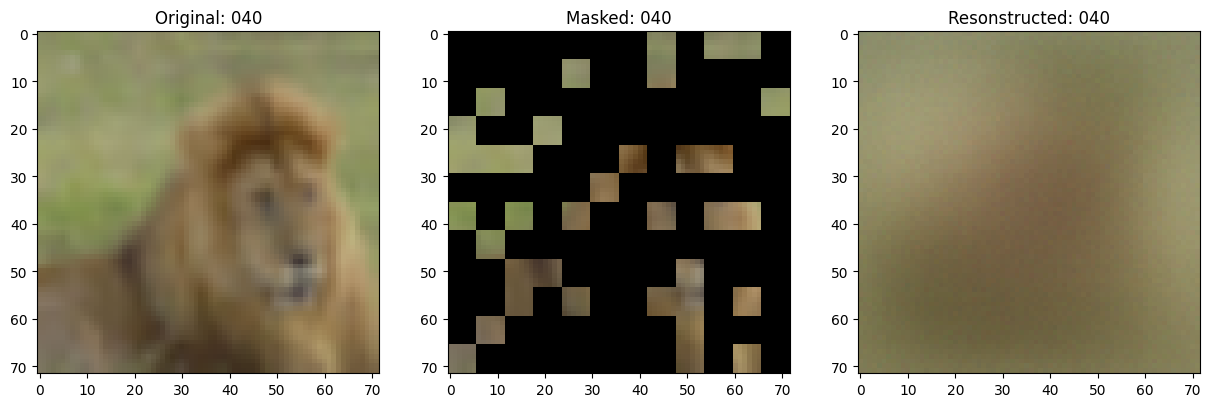

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - mae: 0.0937 - loss: 0.4777 - val_loss: 0.4786 - val_mae: 0.0973 - learning_rate: 1.0000e-10
Epoch 42/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-10
Epoch 43/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4779
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-10
Epoch 44/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4788 - val_mae: 0.0971 - learning_rate: 1.0000e-11
Epoch 45/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4783 - val_mae: 0.0970 - learning_rate: 1.0000e-11
Epoch 46/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4776
Idx chosen: 239


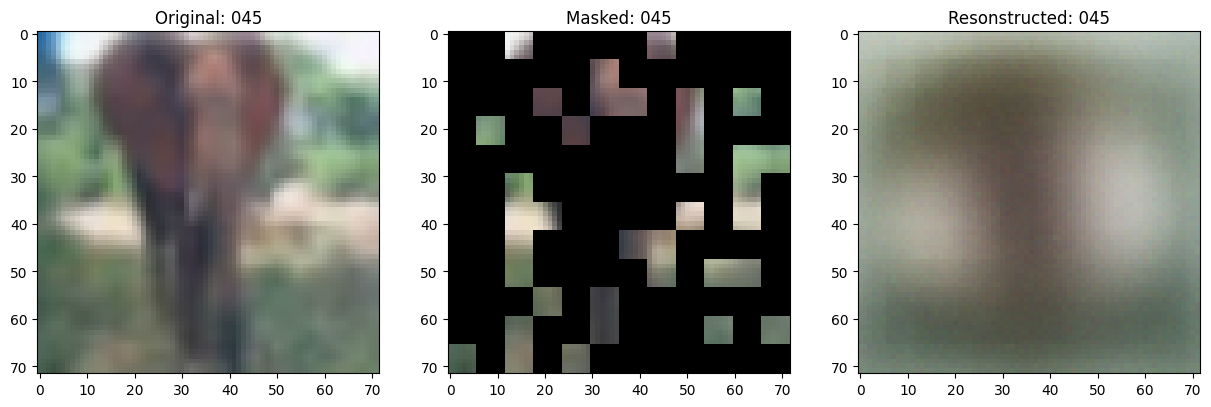

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4785 - val_mae: 0.0970 - learning_rate: 1.0000e-11
Epoch 47/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4785 - val_mae: 0.0971 - learning_rate: 1.0000e-11
Epoch 48/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4778
Epoch 48: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - mae: 0.0937 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-11
Epoch 49/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4783 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-12
Epoch 50/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4785 - val_mae: 0.0971 - learning_rate: 1.0000e-12
Epoch 51/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4775
Idx chosen: 231


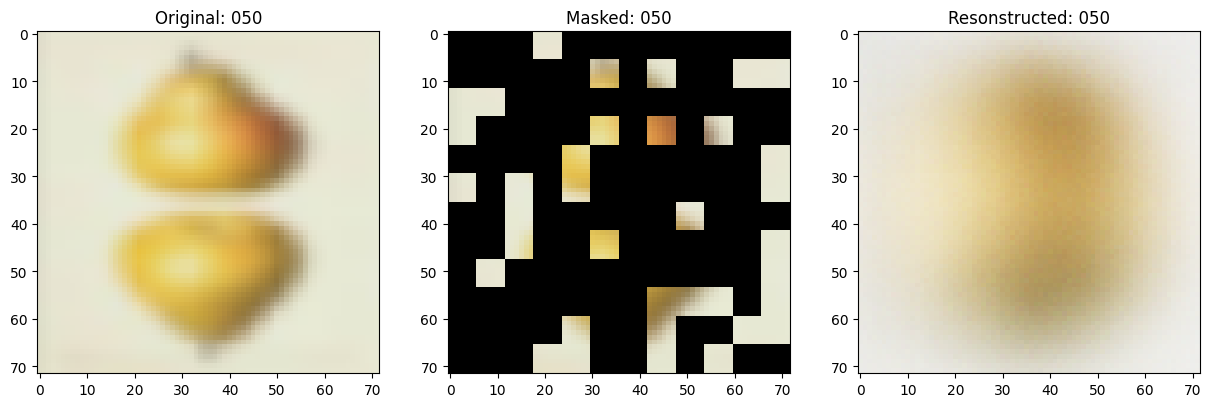

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - mae: 0.0936 - loss: 0.4775 - val_loss: 0.4784 - val_mae: 0.0971 - learning_rate: 1.0000e-12
Epoch 52/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4777 - val_loss: 0.4785 - val_mae: 0.0972 - learning_rate: 1.0000e-12
Epoch 53/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4776
Epoch 53: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4785 - val_mae: 0.0971 - learning_rate: 1.0000e-12
Epoch 54/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4785 - val_mae: 0.0970 - learning_rate: 1.0000e-13
Epoch 55/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4785 - val_mae: 0.0970 - learning_rate: 1.0000e-13
Epoch 56/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4778
Idx chosen: 116


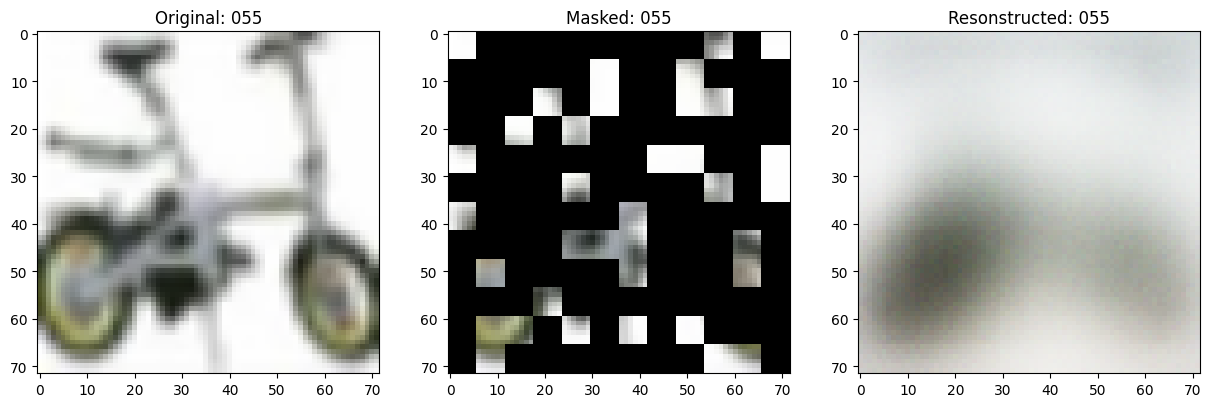

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4788 - val_mae: 0.0971 - learning_rate: 1.0000e-13
Epoch 57/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4777 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-13
Epoch 58/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4778
Epoch 58: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-13
Epoch 59/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4777 - val_loss: 0.4787 - val_mae: 0.0971 - learning_rate: 1.0000e-14
Epoch 60/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4781 - val_loss: 0.4787 - val_mae: 0.0971 - learning_rate: 1.0000e-14
Epoch 61/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4779
Idx chosen: 101


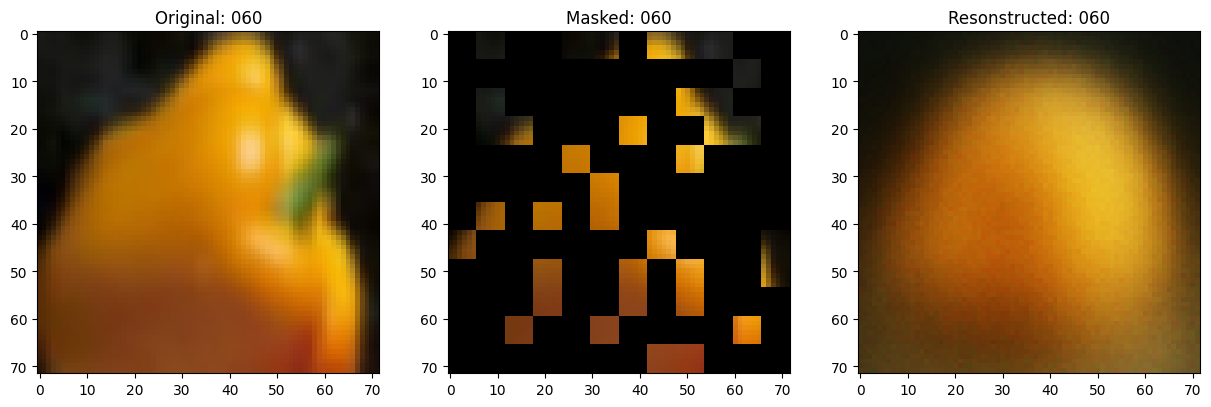

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-14
Epoch 62/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-14
Epoch 63/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4778
Epoch 63: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4778 - val_loss: 0.4785 - val_mae: 0.0972 - learning_rate: 1.0000e-14
Epoch 64/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4788 - val_mae: 0.0970 - learning_rate: 1.0000e-15
Epoch 65/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0937 - loss: 0.4775 - val_loss: 0.4786 - val_mae: 0.0971 - learning_rate: 1.0000e-15
Epoch 66/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - mae: 0.0936 - loss: 0.4779
Idx chosen: 13


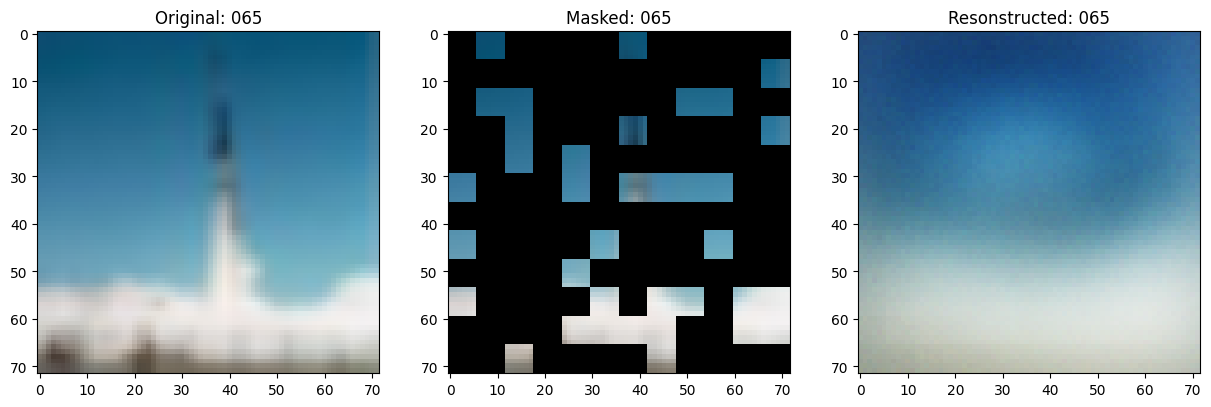

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4785 - val_mae: 0.0972 - learning_rate: 1.0000e-15
Epoch 67/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4778 - val_loss: 0.4784 - val_mae: 0.0970 - learning_rate: 1.0000e-15
Epoch 68/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0937 - loss: 0.4776
Epoch 68: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0937 - loss: 0.4776 - val_loss: 0.4787 - val_mae: 0.0972 - learning_rate: 1.0000e-15
Epoch 69/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4784 - val_mae: 0.0970 - learning_rate: 1.0000e-16
Epoch 70/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4785 - val_mae: 0.0972 - learning_rate: 1.0000e-16
Epoch 71/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4776
Idx chosen: 30


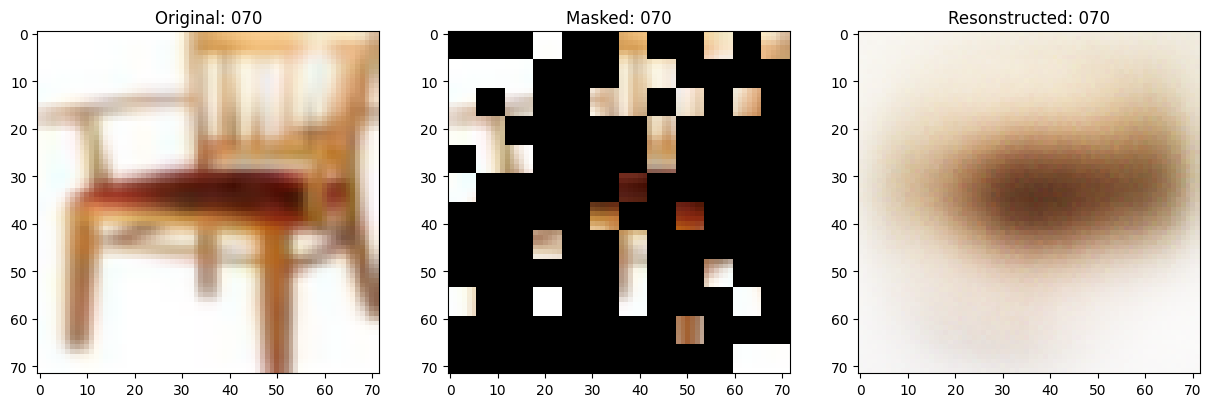

196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - mae: 0.0936 - loss: 0.4776 - val_loss: 0.4786 - val_mae: 0.0970 - learning_rate: 1.0000e-16
Epoch 72/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4779 - val_loss: 0.4784 - val_mae: 0.0972 - learning_rate: 1.0000e-16
Epoch 73/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - mae: 0.0936 - loss: 0.4777
Epoch 73: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - mae: 0.0936 - loss: 0.4777 - val_loss: 0.4789 - val_mae: 0.0971 - learning_rate: 1.0000e-16
Epoch 74/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4788 - val_mae: 0.0971 - learning_rate: 1.0000e-17
Epoch 75/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - mae: 0.0936 - loss: 0.4780 - val_loss: 0.4784 - val_mae: 0.0971 - learning_rate: 1.0000e-17
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - mae: 0.0971 - loss: 0.4783
Loss: 0.48
MAE: 0.10


In [21]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=25, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)

history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), rlp],
)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

# Evaluation on Downstream Classification

In [22]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True

encoder = mae_model.encoder

dropout_rate=0.5

downstream_model = keras.Sequential(
    [
        L.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        L.BatchNormalization(),
        L.GlobalAveragePooling1D(),
        L.Dense(2048, activation=keras.activations.gelu),
        L.Dropout(dropout_rate),
        L.Dense(1024, activation=keras.activations.gelu),
        L.Dropout(dropout_rate),
        L.Dense(10, activation="softmax"),
    ],
    name="downstream_model",
)

In [23]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
train_ds = prepare_data(x_train, y_train)
valid_ds = prepare_data(x_valid, y_valid, is_train=False)

In [24]:
downstream_model.compile(
    optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)

downstream_model.fit(train_ds, validation_data=valid_ds, epochs=75, callbacks=[rlp])

loss, accuracy = downstream_model.evaluate(valid_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/75


I0000 00:00:1724415256.308062  933344 service.cc:146] XLA service 0x7f3c741226c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724415256.308112  933344 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1724415256.308121  933344 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1724415256.308128  933344 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1724415256.308135  933344 service.cc:154]   StreamExecutor device (3): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-08-23 14:14:17.241140: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-23 14:14:19.617237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN versio

  1/196 ━━━━━━━━━━━━━━━━━━━━ 2:18:40 43s/step - accuracy: 0.1406 - loss: 2.5486

I0000 00:00:1724415283.255339  933344 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 97s 278ms/step - accuracy: 0.4082 - loss: 1.6415 - val_accuracy: 0.4275 - val_loss: 1.5220 - learning_rate: 0.0010
Epoch 2/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.5526 - loss: 1.2429 - val_accuracy: 0.4938 - val_loss: 1.3897 - learning_rate: 0.0010
Epoch 3/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5972 - loss: 1.1256 - val_accuracy: 0.5157 - val_loss: 1.4372 - learning_rate: 0.0010
Epoch 4/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.6287 - loss: 1.0483 - val_accuracy: 0.5892 - val_loss: 1.2017 - learning_rate: 0.0010
Epoch 5/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.6399 - loss: 1.0090 - val_accuracy: 0.6031 - val_loss: 1.1703 - learning_rate: 0.0010
Epoch 6/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.6595 - loss: 0.9658 - val_accuracy: 0.6069 - val_loss: 1.1400 - learning_rate: 0.0010
Epoch 7/75
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.6697 - loss:

# References
1. [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/pdf/2111.06377.pdf)
2. [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)